# Filter comparison

NOTE: This notebook is supporting for python 2 only.

## Install pilgram

In [1]:
!pip install pillow pilgram==1.1.0

     |████████████████████████████████| 768kB 4.8MB/s 
  Created wheel for pilgram: filename=pilgram-1.1.0-cp27-none-any.whl size=801518 sha256=3cd2fd70bd662b812976244a70c7b14f8611745a7d9a85c7d60b765215e2965d
  Stored in directory: /root/.cache/pip/wheels/2a/15/2b/761fb601256b3f85db10d9170c1d0d096395d6a5e12e8a07cb
Successfully built pilgram


## Insetall instagram-filters

In [2]:
!sudo DEBIAN_FRONTEND=noninteractive apt-get install -y imagemagick > /dev/null

%cd /content
!git clone https://github.com/acoomans/instagram-filters.git
!sed -i 's/^import Image$/from PIL import Image/' instagram-filters/instagram_filters/filter.py # Fix for using pillow
!pip install --no-deps -e instagram-filters

/content
Cloning into 'instagram-filters'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
Obtaining file:///content/instagram-filters
  Running setup.py develop for instagram-filters


## Setup

In [3]:
!pip install seaborn

In [4]:
%cd /content
!wget -q "https://github.com/akiomik/pilgram/blob/master/notebooks/mtjimba.jpg?raw=true" -O mtjimba.jpg

/content


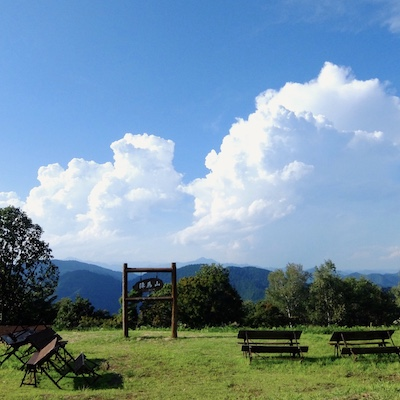

In [5]:
from time import time
import shutil

from IPython import display
import matplotlib.pyplot as plt
from PIL import Image


N_LOOPS = 500  # @param

original_image_name = '/content/mtjimba.jpg'
pg_image_names = ['/content/pg_kelvin_mtjimba.jpg', '/content/pg_nashville_mtjimba.jpg', '/content/pg_toaster_mtjimba.jpg']
if_image_names = ['/content/if_Kelvin_mtjimba.jpg', '/content/if_Nashville_mtjimba.jpg', '/content/if_Toaster_mtjimba.jpg']

display.display_jpeg(display.Image(original_image_name))

## Run pilgram

In [6]:
%%time
%cd /content

import pilgram


pg_filter_names = ['kelvin', 'nashville', 'toaster']
pg_elapsed_time = {}

for filter_name, image_name in zip(pg_filter_names, pg_image_names):
  time1 = time()
  for i in range(N_LOOPS):
    shutil.copy(original_image_name, image_name)
    filter = getattr(pilgram, filter_name)
    im = Image.open(image_name)
    im2 = filter(im)
    im2.save(image_name)
  time2 = time()
  pg_elapsed_time[filter_name] = time2 - time1

/content
CPU times: user 38.5 s, sys: 1.18 s, total: 39.7 s
Wall time: 40.1 s


## Run instagram-filters

In [7]:
%%time
%cd /content/instagram-filters

from instagram_filters import filters


if_filter_names = ['Kelvin', 'Nashville', 'Toaster']
if_elapsed_time = {}

for filter_name, image_name in zip(if_filter_names, if_image_names):
  time1 = time()
  for i in range(N_LOOPS):
    shutil.copy(original_image_name, image_name)
    filter = getattr(filters, filter_name)
    f = filter(image_name)
    f.apply()
  time2 = time()
  if_elapsed_time[filter_name] = time2 - time1

/content/instagram-filters
CPU times: user 5.52 s, sys: 16.6 s, total: 22.1 s
Wall time: 5min 23s


## Comparison

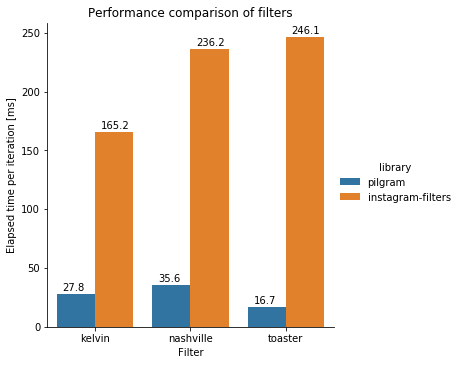

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns


elapsed_time = pg_elapsed_time.values() + if_elapsed_time.values()
elapsed_time_ms = np.array(elapsed_time) / N_LOOPS * 1000
df = pd.DataFrame(data={
  'library': ['pilgram'] * 3 + ['instagram-filters'] * 3,
  'filter': pg_filter_names * 2,
  'elapsed_time': elapsed_time_ms,
})

g = sns.catplot(x = 'filter', y = 'elapsed_time', hue='library', data = df, kind = 'bar')
g.set_axis_labels("Filter", "Elapsed time per iteration [ms]")
g.ax.set_title("Performance comparison of filters")
for p in g.ax.patches:
  x = p.get_x() + .06
  y = p.get_height() + 3
  g.ax.annotate('{:.1f}'.format(p.get_height()), (x, y))
plt.show()

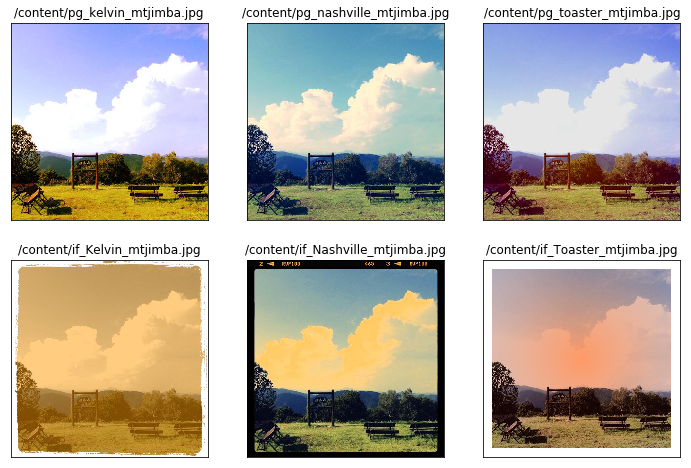

In [9]:
image_names = pg_image_names + if_image_names
rows = 2
columns = len(pg_image_names)
fig = plt.figure(figsize=(columns * 4, rows * 4))
for i, image_name in enumerate(image_names):
  im = Image.open(image_name)
  ax = fig.add_subplot(rows, columns, i + 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(image_name)
  ax.imshow(im)
plt.show()